# Pytorch

## Review
_Quick Start_  
_https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html_

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Pytorch'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
train_ds = torchvision.datasets.FashionMNIST(
                    data_path,
                    train=True,
                    download=True,
                    transform=torchvision.transforms.ToTensor()
)
test_ds = torchvision.datasets.FashionMNIST(
                    data_path,
                    train=False,
                    download=True,
                    transform=torchvision.transforms.ToTensor()
)

In [ ]:
train_ds[0][0].size()

torch.Size([1, 28, 28])

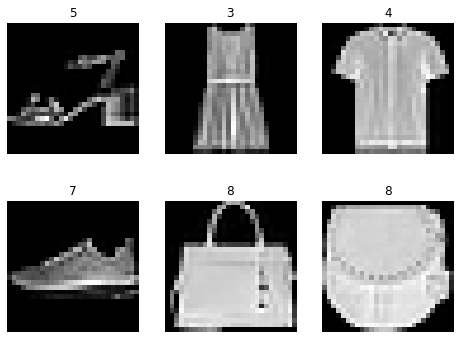

In [ ]:
fig = plt.figure(figsize=(8, 6))

for i in range(1, 7):
  idx = torch.randint(len(train_ds), size=(1,)).item()
  image, label = train_ds[idx]
  image = image.view(28, 28)

  fig.add_subplot(2, 3, i)
  plt.title(label)
  plt.imshow(image, cmap='gray')
  plt.grid(False)
  plt.axis(False)

plt.show()

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
                train_ds,
                shuffle=True,
                batch_size=batch_size,
                num_workers=2
)
testloader = torch.utils.data.DataLoader(
                test_ds,
                batch_size=batch_size,
                num_workers=2
)

len(trainloader), len(testloader)

(938, 157)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc_1 = nn.Linear(28*28, 8)
    self.fc_2 = nn.Linear(8, 16)
    self.fc_3 = nn.Linear(16, 10)


  def forward(self, x):
    out = torch.flatten(x, 1)
    out = F.relu(self.fc_1(out))
    out = F.relu(self.fc_2(out))
    out = self.fc_3(out)
    return out

In [ ]:
model = Net().to(device)
model

Net(
  (fc_1): Linear(in_features=784, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=16, bias=True)
  (fc_3): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(model, dataloader, loss_fn, optimizer):
  for i, data in enumerate(dataloader):
    X, y = data
    X, y = X.to(device), y.to(device)
    
    model.train()
    outputs = model(X)
    loss = loss_fn(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print(f'Loss: {loss:.3f} [{i*len(X)}/{len(dataloader.dataset)}]')

In [ ]:
def test(model, dataloader, loss_fn):
  total_loss, correct = 0., 0
  for i, data in enumerate(dataloader):
    with torch.no_grad():
      X, y = data
      X, y = X.to(device), y.to(device)

      model.eval()
      outputs = model(X)
      correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

      loss = loss_fn(outputs, y)
      total_loss += loss.item()
  print(f'Test Accuracy: {correct/len(dataloader.dataset)} Avg Loss: {total_loss/len(dataloader):.3f}')

In [ ]:
epochs=1
for i in range(epochs):
  print(f'Epochs: {i+1} ---------------------------------')
  train(model, trainloader, loss_fn, optimizer)
  test(model, testloader, loss_fn)
  print()

Epochs: 1 ---------------------------------
Loss: 2.327 [0/60000]
Loss: 2.315 [6400/60000]
Loss: 2.320 [12800/60000]
Loss: 2.308 [19200/60000]
Loss: 2.301 [25600/60000]
Loss: 2.315 [32000/60000]
Loss: 2.301 [38400/60000]
Loss: 2.300 [44800/60000]
Loss: 2.313 [51200/60000]
Loss: 2.308 [57600/60000]
Test Accuracy: 0.1156 Avg Loss: 2.292



## Ray Tune
___Hyper Parameter Tuning___  
___Using Model classifying CIFAR-10___

It is referred to 
 - _https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html_
 - _https://docs.ray.io/en/latest/tune/index.html_

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Pytorch'

In [ ]:
%%capture
# install the package needed
!pip install ray[tune]

In [ ]:
import numpy as np
import os
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# for hyper parameter tuning, only need to import 3 modules
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

### Data

In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

```
transforms.Normalize(  
    mean,  
    std,  
    inplace=False 
)
```
mean and std is applied for each channel of image  
Ex) 'mean=(0, 0, 0)' matchs 3 channel

In [ ]:
path = data_path + '/RayTune'
train_ds, test_ds = load_data(path)
len(train_ds), len(test_ds)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

### Model

In [ ]:
class Net(nn.Module):
  def __init__(self, l1, l2):
    super().__init__()
    self.conv_1 = nn.Conv2d(3, 6, 5)
    self.conv_2 = nn.Conv2d(6, 16, 5)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc_1 = nn.Linear(16*5*5, l1)
    self.fc_2 = nn.Linear(l1, l2)
    self.fc_3 = nn.Linear(l2, 10)

  
  def forward(self, x):
    out = self.pool(F.relu(self.conv_1(x)))
    out = self.pool(F.relu(self.conv_2(out)))
    out = torch.flatten(out, 1)

    out = F.relu(self.fc_1(out))
    out = F.relu(self.fc_2(out))
    logits = self.fc_2(out)

    return logits

In [ ]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
  sw = True
  net = Net(config['l1'], config['l2'])

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  if device == 'cude':
    if torch.cuda.device_count() > 1:
      net = nn.DataParallel(net)
  net.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=config['lr'], momentum=0.9)

  if checkpoint_dir:
    model_state, optimizer_state = torch.load(
        os.path.join(checkpoint_dir, "checkpoint"))
    net.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)

  train_ds, test_ds = load_data(data_dir)
  len_train = int(len(train_ds)*0.8)
  train_subset, val_subset = random_split

  len_train = int(len(train_ds)*0.8)
  train_ds, val_ds = random_split(train_ds, [len_train, len(train_ds)-len_train])
  
  trainloader = torch.utils.data.DataLoader(
                    train_ds,
                    batch_size=int(config['batch_size']),
                    shuffle=True,
                    num_workers=8
  )
  valloader = torch.utils.data.DataLoader(
                    val_ds,
                    batch_size=int(config['batch_size']),
                    shuffle=True,
                    num_workers=8
  )

  for epoch in range(10):
    running_loss = 0.
    epoch_steps = 0
    for i, data in enumerate(trainloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      epoch_steps += 1
      if i % 2000 == 1999:
        print("[%d, %5d] loss: %.3f" % (epoch+1, epoch_steps, running_loss/epoch_steps))
      
    val_loss = 0.
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(valloader):
      with torch.no_grad():
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        ###
        if sw:
          print(type(outputs))
          print(outputs.data)
          sw = False
        ###
        _, pred = torch.max(outputs.data, 1)
        correct += (pred.item() == labels).sum().item()
        total += labels.size(0)
        loss = criterion(outputs, labels)
        val_loss += loss.cpu().numpy()
        val_steps += 1



### 실습

In [ ]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

Most of the imports are needed for building the PyTorch model. Only the last three
imports are for Ray Tune.

Data loaders
------------
We wrap the data loaders in their own function and pass a global data directory.
This way we can share a data directory between different trials.



In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

Configurable neural network
---------------------------
We can only tune those parameters that are configurable. In this example, we can specify
the layer sizes of the fully connected layers:



In [ ]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The train function
------------------
Now it gets interesting, because we introduce some changes to the example `from the PyTorch
documentation <https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html>`_.

We wrap the training script in a function ``train_cifar(config, checkpoint_dir=None, data_dir=None)``.
As you can guess, the ``config`` parameter will receive the hyperparameters we would like to
train with. The ``checkpoint_dir`` parameter is used to restore checkpoints. The ``data_dir`` specifies
the directory where we load and store the data, so multiple runs can share the same data source.

.. code-block:: python

    net = Net(config["l1"], config["l2"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

The learning rate of the optimizer is made configurable, too:

.. code-block:: python

    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

We also split the training data into a training and validation subset. We thus train on
80% of the data and calculate the validation loss on the remaining 20%. The batch sizes
with which we iterate through the training and test sets are configurable as well.

Adding (multi) GPU support with DataParallel
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Image classification benefits largely from GPUs. Luckily, we can continue to use
PyTorch's abstractions in Ray Tune. Thus, we can wrap our model in ``nn.DataParallel``
to support data parallel training on multiple GPUs:

.. code-block:: python

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

By using a ``device`` variable we make sure that training also works when we have
no GPUs available. PyTorch requires us to send our data to the GPU memory explicitly,
like this:

.. code-block:: python

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

The code now supports training on CPUs, on a single GPU, and on multiple GPUs. Notably, Ray
also supports `fractional GPUs <https://docs.ray.io/en/master/using-ray-with-gpus.html#fractional-gpus>`_
so we can share GPUs among trials, as long as the model still fits on the GPU memory. We'll come back
to that later.

Communicating with Ray Tune
~~~~~~~~~~~~~~~~~~~~~~~~~~~

The most interesting part is the communication with Ray Tune:

.. code-block:: python

    with tune.checkpoint_dir(epoch) as checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save((net.state_dict(), optimizer.state_dict()), path)

    tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

Here we first save a checkpoint and then report some metrics back to Ray Tune. Specifically,
we send the validation loss and accuracy back to Ray Tune. Ray Tune can then use these metrics
to decide which hyperparameter configuration lead to the best results. These metrics
can also be used to stop bad performing trials early in order to avoid wasting
resources on those trials.

The checkpoint saving is optional, however, it is necessary if we wanted to use advanced
schedulers like
`Population Based Training <https://docs.ray.io/en/master/tune/tutorials/tune-advanced-tutorial.html>`_.
Also, by saving the checkpoint we can later load the trained models and validate them
on a test set.

Full training function
~~~~~~~~~~~~~~~~~~~~~~

The full code example looks like this:



In [ ]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    ##################################################
    print(next(net.parameters()).is_cuda)
    ##################################################

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2022-08-02 09:25:57,304	WARNING tune.py:669 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


== Status ==
Current time: 2022-08-02 09:25:57 (running for 00:00:00.19)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar_2022-08-02_09-25-57
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_1d5ca_00000 | RUNNING  | 172.28.0.2:3068 |           16 |   64 |   64 | 0.000852711 |
| train_cifar_1d5ca_00001 | PENDING  |                 |           16 |  256 |   16 | 0.00029796  |
| train_cifar_1d5ca_00002 | PENDING  |   

(func pid=3068) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=3068)   cpuset_checked))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
| train_cifar_1d5ca_00009 | PENDING    |                 |            4 |    8 |   16 | 0.000993305 |         |            |                      |
| train_cifar_1d5ca_00000 | TERMINATED | 172.28.0.2:3068 |           16 |   64 |   64 | 0.000852711 | 1.16311 |     0.5953 |                   10 |
| train_cifar_1d5ca_00001 | TERMINATED | 172.28.0.2:3068 |           16 |  256 |   16 | 0.00029796  | 2.22674 |     0.1934 |                    1 |
| train_cifar_1d5ca_00002 | TERMINATED | 172.28.0.2:3068 |            2 |   16 |  128 | 0.0285343   | 2.32098 |     0.1032 |                    1 |
| train_cifar_1d5ca_00003 | TERMINATED | 172.28.0.2:3068 |            8 |    8 |   64 | 0.00449389  | 1.44947 |     0.477  |                    4 |
+-------------------------+------------+-----------------+--------------+------+------+-------------+---------+------------+----------------------+


== Status ==
Current time: 2022-08-02 09:38:44 (running for 00:12:47.18)
M

2022-08-02 09:55:28,404	INFO tune.py:748 -- Total run time: 1771.11 seconds (1770.97 seconds for the tuning loop).


Result for train_cifar_1d5ca_00009:
  accuracy: 0.523
  date: 2022-08-02_09-55-28
  done: true
  experiment_id: ada73034c878484d8be947b50b1a6628
  hostname: 3c87a96c0fb6
  iterations_since_restore: 8
  loss: 1.3947163203209638
  node_ip: 172.28.0.2
  pid: 3068
  should_checkpoint: true
  time_since_restore: 478.96084237098694
  time_this_iter_s: 59.168838024139404
  time_total_s: 478.96084237098694
  timestamp: 1659434128
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 1d5ca_00009
  warmup_time: 0.0030655860900878906
  
== Status ==
Current time: 2022-08-02 09:55:28 (running for 00:29:30.99)
Memory usage on this node: 1.9/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -1.2538961165428162 | Iter 4.000: -1.377194934949279 | Iter 2.000: -1.5617577179908753 | Iter 1.000: -1.8565384273767471
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar_2022-08

In [ ]:
data_path = './data'

config = {'lr': 1e-3,
          'l1': 8,
          'l2': 16,
          'batch_size': 64}
train_cifar(config, data_dir=data_path)

True
Files already downloaded and verified
Files already downloaded and verified


2022-08-02 10:01:54,980	WARNING session.py:35 -- Session not detected. You should not be calling `checkpoint_dir` outside `tune.run` or while using the class API. 
2022-08-02 10:01:54,982	WARNING session.py:38 --   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "

Finished Training
